In [1]:
import geopandas as gpd
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import r2_score
import rasterio
from matplotlib.colors import ListedColormap
from rasterio.features import geometry_window
from rasterio.mask import mask
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score

In [2]:
#q1

counties_gdf = gpd.read_file("counties.geojson")
num_counties = len(counties_gdf)
num_counties

72

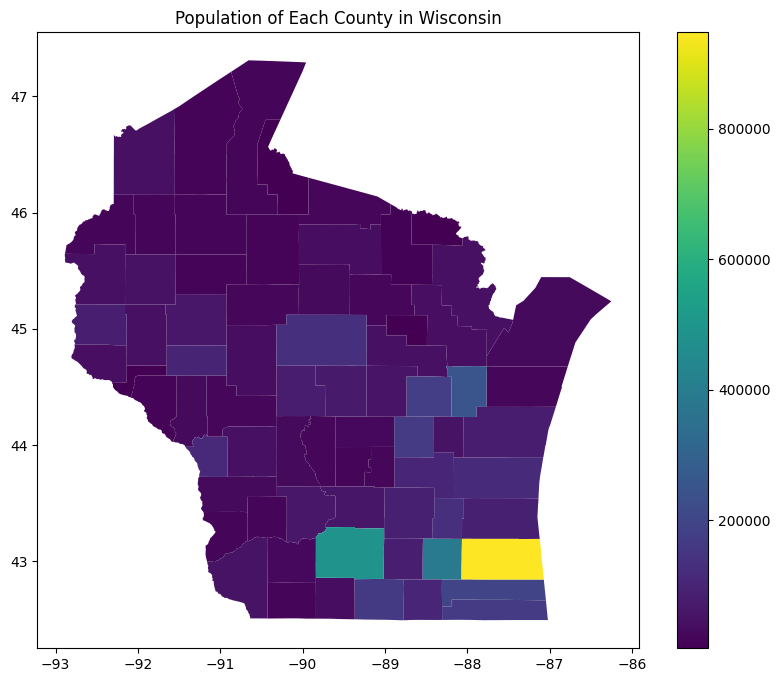

In [3]:
#q2

counties_gdf.plot(column="POP100", legend=True, cmap="viridis", figsize=(10, 8))
plt.title("Population of Each County in Wisconsin")
plt.show()

In [4]:
conn = sqlite3.connect("counties_tracts.db")
print(pd.read_sql("""SELECT * FROM sqlite_master""", conn))

    type               name  tbl_name  rootpage  \
0  table           counties  counties         2   
1  index  ix_counties_index  counties         3   
2  table             tracts    tracts         4   
3  index    ix_tracts_index    tracts         5   

                                                 sql  
0  CREATE TABLE "counties" (\n"index" INTEGER,\n ...  
1  CREATE INDEX "ix_counties_index"ON "counties" ...  
2  CREATE TABLE "tracts" (\n"index" INTEGER,\n  "...  
3  CREATE INDEX "ix_tracts_index"ON "tracts" ("in...  


In [5]:
counties_df = pd.read_sql("""SELECT * FROM counties""", conn)
print(counties_df.head())

   index            NAME COUNTY    AREALAND   AREAWATER
0      0   Racine County    101   861533739  1190103013
1      1    Clark County    019  3133378070    23239614
2      2     Wood County    141  2054044751    41994799
3      3     Rusk County    107  2366092584    44813690
4      4  Ozaukee County    089   603514413  2287415379


In [6]:
tracts_df = pd.read_sql("""SELECT * FROM tracts""", conn)
tracts_df

,index,NAME,COUNTY,HU100
0,0,Census Tract 9701.01,085,2760
1,1,Census Tract 9710.01,085,1536
2,2,Census Tract 9706.01,085,1208
3,3,Census Tract 9706.02,085,3136
4,4,Census Tract 4301,131,2144
...,...,...,...,...
1404,1404,Census Tract 14,059,2913
1405,1405,Census Tract 15,059,1550
1406,1406,Census Tract 16,059,1286
1407,1407,Census Tract 17,059,1068


In [7]:
counties_gdf = counties_gdf.merge(
    counties_df[["NAME", "AREALAND", "COUNTY"]],
    on="NAME",
    how="left"
)

In [8]:
counties_gdf

,NAME,POP100,geometry,AREALAND,COUNTY
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739,101
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070,019
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.7246 44.3384...",2054044751,141
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",2366092584,107
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",603514413,089
...,...,...,...,...,...
67,Washburn County,15911,"POLYGON ((-91.55065 46.07034, -91.55065 46.070...",2064515991,129
68,Monroe County,44673,"POLYGON ((-90.55246 43.72565, -90.55096 43.725...",2333270295,081
69,Richland County,18021,"POLYGON ((-90.31107 43.55399, -90.31108 43.553...",1518120276,103
70,Price County,14159,"POLYGON ((-90.04485 45.81765, -90.0444 45.8303...",3248866440,099


In [9]:
train_set, test_set = train_test_split(counties_gdf, test_size=0.25, random_state=320)

In [10]:
#q3

test_counties = test_set["NAME"].tolist()
test_counties

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [11]:
#q4

X_train = train_set[["AREALAND"]]
y_train = train_set["POP100"]

X_test = test_set[["AREALAND"]]
y_test = test_set["POP100"]

model = LinearRegression()
model.fit(X_train, y_train)

r2_score_q4 = model.score(X_test, y_test)
r2_score_q4

0.022002661530554857

In [12]:
#q5

area_in_sq_meters = 300 * 2.59 * 1_000_000
predicted_population = model.predict([[area_in_sq_meters]])[0]
float(predicted_population)

/home/riyakore/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


89016.40396725974

In [13]:
hu100_query = """
    SELECT tracts.COUNTY, SUM(tracts.HU100) as HU100
    FROM tracts
    GROUP BY tracts.COUNTY
"""

hu100_df = pd.read_sql(hu100_query, conn)

counties_gdf = counties_gdf.merge(
    hu100_df,
    left_on="COUNTY",
    right_on="COUNTY",
    how="left"
)

counties_gdf

,NAME,POP100,geometry,AREALAND,COUNTY,HU100
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739,101,82164
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070,019,15076
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.7246 44.3384...",2054044751,141,34088
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",2366092584,107,8883
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",603514413,089,36267
...,...,...,...,...,...,...
67,Washburn County,15911,"POLYGON ((-91.55065 46.07034, -91.55065 46.070...",2064515991,129,12979
68,Monroe County,44673,"POLYGON ((-90.55246 43.72565, -90.55096 43.725...",2333270295,081,19204
69,Richland County,18021,"POLYGON ((-90.31107 43.55399, -90.31108 43.553...",1518120276,103,8868
70,Price County,14159,"POLYGON ((-90.04485 45.81765, -90.0444 45.8303...",3248866440,099,11120


In [14]:
train_set, test_set = train_test_split(counties_gdf, test_size=0.25, random_state=320)

In [15]:
#q6

test_counties = test_set["NAME"].tolist()
test_counties

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [16]:
#q7

test_hu100_dict = dict(zip(test_set["NAME"], test_set["HU100"]))
test_hu100_dict

{'Kewaunee County': 9304,
 'Calumet County': 19695,
 'Adams County': 17436,
 'Eau Claire County': 42151,
 'Milwaukee County': 418053,
 'Ashland County': 9656,
 'Wood County': 34088,
 'Dodge County': 37005,
 'Sauk County': 29708,
 'Clark County': 15076,
 'Pepin County': 3579,
 'Taylor County': 10582,
 'Iron County': 5999,
 'Outagamie County': 73149,
 'Florence County': 4780,
 'Oneida County': 30125,
 'Pierce County': 16132,
 'Grant County': 21581}

In [17]:
#q8

X_train_hu100 = train_set[["HU100"]]
y_train_pop100 = train_set["POP100"]

model_hu100 = LinearRegression()

cv_scores = cross_val_score(model_hu100, X_train_hu100, y_train_pop100, cv=5, scoring='r2')

cv_average_score = np.mean(cv_scores)
float(cv_average_score)

0.9652534544116037

In [18]:
#q9

cv_variance = np.mean((cv_scores - cv_average_score) ** 2)
cv_std_dev = np.sqrt(cv_variance)
float(cv_std_dev)

0.03704265206670459

In [19]:
#q10

model_hu100.fit(X_train_hu100, y_train_pop100)
coef = round(model_hu100.coef_[0], 2)
intercept = round(model_hu100.intercept_, 2)
formula = f"POP100 = {coef}*HU100 + {intercept}"
formula

'POP100 = 2.39*HU100 + -7910.46'

In [20]:
#q11

X_test_hu100 = test_set[["HU100"]]
y_test_pop100 = test_set["POP100"]

y_pred_test = model_hu100.predict(X_test_hu100)
r2_test_score = r2_score(y_test_pop100, y_pred_test)
r2_test_score

0.9958323488562859

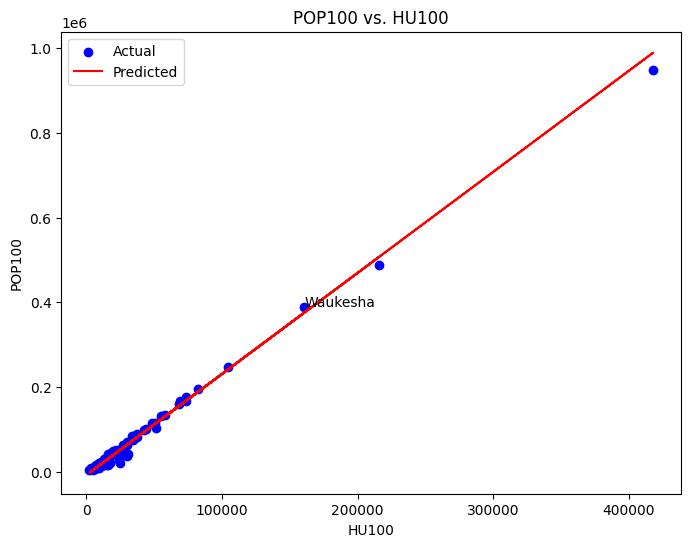

In [21]:
#q12

full_set = pd.concat([train_set, test_set])
X_full_hu100 = full_set[["HU100"]]
y_full_pop100 = full_set["POP100"]

y_full_pred = model_hu100.predict(X_full_hu100)

plt.figure(figsize=(8, 6))
plt.scatter(X_full_hu100, y_full_pop100, color='blue', label='Actual')
plt.plot(X_full_hu100, y_full_pred, color='red', label='Predicted')

waukesha_index = full_set[full_set["NAME"] == "Waukesha County"].index
if not waukesha_index.empty:
    waukesha_x = X_full_hu100.loc[waukesha_index].values[0][0]
    waukesha_y = y_full_pop100.loc[waukesha_index].values[0]
    plt.text(waukesha_x, waukesha_y, "Waukesha", fontsize=10)

plt.xlabel("HU100")
plt.ylabel("POP100")
plt.title("POP100 vs. HU100")
plt.legend()
plt.show()

In [22]:
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

In [23]:
#q13

count = np.sum((A >= 1) & (A <= 4))
int(count)

13

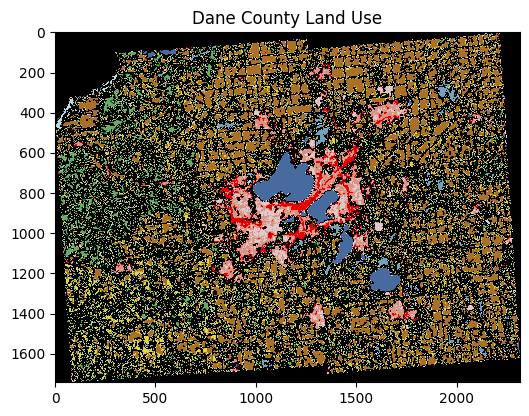

In [24]:
#q14

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

with rasterio.open("zip://./land.zip!/wi.tif") as src:
    dane_geometry = counties_gdf[counties_gdf["NAME"] == "Dane County"]["geometry"].values[0]
    dane_geometry_gs = gpd.GeoSeries([dane_geometry], crs=counties_gdf.crs)
    dane_geometry_reprojected = dane_geometry_gs.to_crs(src.crs).iloc[0]
    dane_data, dane_transform = mask(src, [dane_geometry_reprojected], crop=True, nodata=0)
    dane_data = dane_data[0]

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(dane_data, cmap=custom_cmap, vmin=0, vmax=255)
ax.set_title("Dane County Land Use")
plt.show()

In [25]:
#q15

land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

crops_code = land_use["crops"]
dane_county_cells = dane_data[dane_data != 0]
crops_cells = np.sum(dane_county_cells == crops_code)
total_dane_county_cells = dane_county_cells.size
crops_portion = crops_cells / total_dane_county_cells
float(crops_portion)

0.46705544316564085

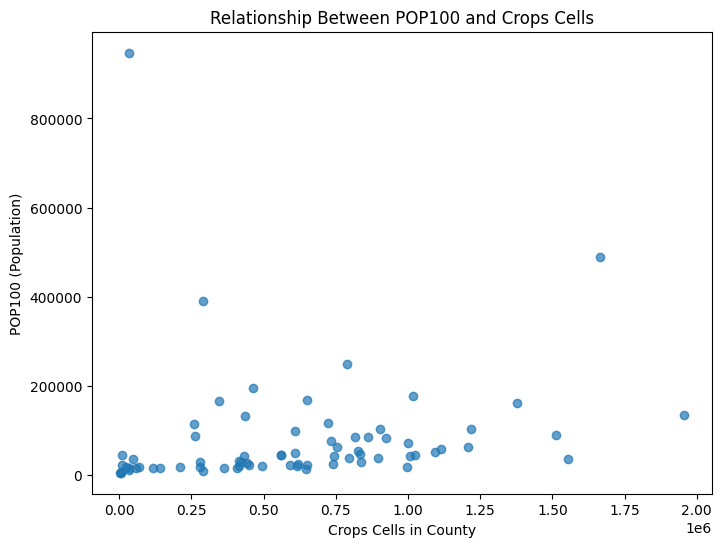

In [26]:
#q16

chosen_land_type = "crops"
land_type_code = land_use[chosen_land_type]
land_type_counts = []

with rasterio.open("zip://./land.zip!/wi.tif") as src:
    raster_crs = src.crs
    
    counties_gdf = counties_gdf.to_crs(raster_crs)
    
    for _, county in counties_gdf.iterrows():
        county_geometry = county["geometry"]
        
        try:
            county_data, county_transform = mask(src, [county_geometry], crop=True, nodata=0)
            county_data = county_data[0]
            
            count = np.sum(county_data == land_type_code)
        except ValueError:
            count = 0
        
        land_type_counts.append(count)

counties_gdf[f"{chosen_land_type}_cells"] = land_type_counts

plt.figure(figsize=(8, 6))
plt.scatter(counties_gdf[f"{chosen_land_type}_cells"], counties_gdf["POP100"], alpha=0.7)
plt.title(f"Relationship Between POP100 and {chosen_land_type.capitalize()} Cells")
plt.xlabel(f"{chosen_land_type.capitalize()} Cells in County")
plt.ylabel("POP100 (Population)")
plt.show()

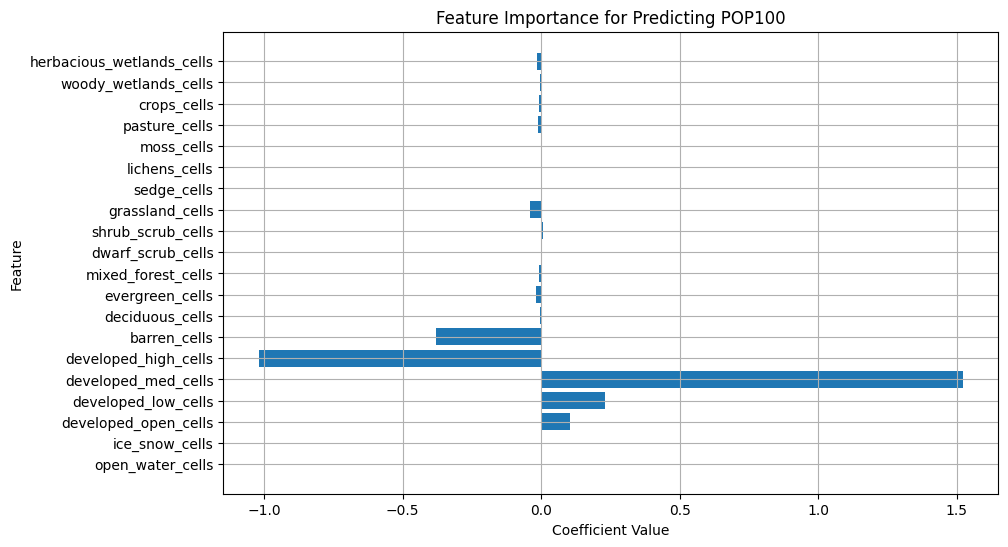

In [27]:
#q17

tracts_gdf = gpd.read_file("tracts.shp")
land_type_counts = {key: [] for key in land_use.keys()}

with rasterio.open("zip://./land.zip!/wi.tif") as src:
    raster_crs = src.crs
    tracts_gdf = tracts_gdf.to_crs(raster_crs)
    
    for _, tract in tracts_gdf.iterrows():
        tract_geometry = tract["geometry"]
        try:
            tract_data, _ = mask(src, [tract_geometry], crop=True, nodata=0)
            tract_data = tract_data[0]
            
            for land_type, code in land_use.items():
                count = np.sum(tract_data == code)
                land_type_counts[land_type].append(count)
        except ValueError:
            for land_type in land_use.keys():
                land_type_counts[land_type].append(0)
                
for land_type, counts in land_type_counts.items():
    tracts_gdf[f"{land_type}_cells"] = counts

X = tracts_gdf[[f"{land_type}_cells" for land_type in land_use.keys()]]
y = tracts_gdf["POP100"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=320)

model = LinearRegression()
model.fit(X_train, y_train)

coefficients = model.coef_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, coefficients)
plt.title("Feature Importance for Predicting POP100")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

# the bar plot displays the coefficients of the features (land-use types) in the linear regression model trained to predict population
# (POP100) for each census tract. The magnitude of the coefficients represents the importance of the correspnding feature in 
# predicting the population.

# 1. Positive coefficients
# features with positive coefficents contribute positively to the prediction of population.
# for example, developed_med_cells shows a strong positive coefficient, which indicates that the area with medium intensity 
# development has a significant positive correlation with population.

# 2. Negative coefficents
# features with negative coefficients like barren_cells and developed_high_cells negatively impact the population prediction.
# this suggests that areas with barren land or high development are inversly correlated with population.

# 3. near-zero coefficients
# features with coefficients close to zero, such as herbacious_wetlands_cells or crops_cells contribute minimally to the prediction.
# these land use types may not be strongly associated with population levels.

# how to use this information to build a model?
# feature selection: The graph provides valuable insights for feature selection. 
# features with near-zero coefficients can be excluded to reduce model complexity without sacrificing predictive power.
# interpretability: The plot highlights which land-use types are most predictive of population. 
# For instance, areas with developed_med_cells are clear indicators of population density and can be emphasized in the model.
# domain insights: The results align with expectations that developed areas are highly correlated with population, 
# while barren or less-developed regions have minimal or negative impact. 
# This understanding can guide domain-specific improvements or feature engineering.

## Comments on the plot for question 17:

The bar plot displays the coefficients of the features (land-use types) in the linear regression model trained to predict population (POP100) for each census tract. The magnitude of the coefficients represents the importance of the correspnding feature in predicting the population.

#### 1. Positive coefficients
Features with positive coefficents contribute positively to the prediction of population. For example, developed_med_cells shows a strong positive coefficient, which indicates that the area with medium intensity development has a significant positive correlation with population.

#### 2. Negative coefficents
Features with negative coefficients like barren_cells and developed_high_cells negatively impact the population prediction. This suggests that areas with barren land or high development are inversly correlated with population.

#### 3. near-zero coefficients
Features with coefficients close to zero, such as herbacious_wetlands_cells or crops_cells contribute minimally to the prediction. These land use types may not be strongly associated with population levels.

## How to use this information to build a model?
#### Feature Selection: 
The graph provides valuable insights for feature selection. Features with near-zero coefficients can be excluded to reduce model complexity without sacrificing predictive power.
#### Interpretability: 
The plot highlights which land-use types are most predictive of population. For instance, areas with developed_med_cells are clear indicators of population density and can be emphasized in the model.
#### Domain Insights: 
The results align with expectations that developed areas are highly correlated with population, while barren or less-developed regions have minimal or negative impact. This understanding can guide domain-specific improvements or feature engineering.

In [28]:
#q18

model1 = LinearRegression()

model2 = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(random_state=320))
])

cv_scores_model1 = cross_val_score(model1, X_train, y_train, cv=5, scoring='explained_variance')
cv_scores_model2 = cross_val_score(model2, X_train, y_train, cv=5, scoring='explained_variance')

results = {
    'model1-avg': float(np.mean(cv_scores_model1)),
    'model1-std': float(np.std(cv_scores_model1)),
    'model2-avg': float(np.mean(cv_scores_model2)),
    'model2-std': float(np.std(cv_scores_model2))
}

results

# Model 2 outperforms Model 1 in terms of both higher mean explained variance and lower variance in cross-validation scores. 
# A higher mean score indicates that Model 2 provides better predictions on average, and a lower standard deviation implies 
# that Model 2's performance is more consistent across different folds.

# Random Forest in Model 2 likely captures non-linear relationships in the data better than the Linear Regression 
# model in Model 1, which explains the improved performance.

# Model 2 includes feature scaling (via StandardScaler) and a more sophisticated learning algorithm (Random Forest Regressor), 
# making it slightly more complex but significantly more effective.

# I recommend Model 2 for this prediction task due to its higher predictive accuracy and consistent performance. 
# While it is slightly more complex, the improvement in predictive capability justifies the additional complexity.

{'model1-avg': 0.5167208844500124,
 'model1-std': 0.023775183087829523,
 'model2-avg': 0.5710502477786014,
 'model2-std': 0.02276734983378869}

## Comments for question 18:

- Model 2 outperforms Model 1 in terms of both higher mean explained variance and lower variance in cross-validation scores. A higher mean score indicates that Model 2 provides better predictions on average, and a lower standard deviation implies that Model 2's performance is more consistent across different folds.

- Random Forest in Model 2 likely captures non-linear relationships in the data better than the Linear Regression model in Model 1, which explains the improved performance.

- Model 2 includes feature scaling (via StandardScaler) and a more sophisticated learning algorithm (Random Forest Regressor), making it slightly more complex but significantly more effective.

- I recommend Model 2 for this prediction task due to its higher predictive accuracy and consistent performance. While it is slightly more complex, the improvement in predictive capability justifies the additional complexity.

In [29]:
#q19

recommended_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(random_state=320))
])

recommended_model.fit(X_train, y_train)

test_score = explained_variance_score(y_test, recommended_model.predict(X_test))
test_score

0.4820782212257567